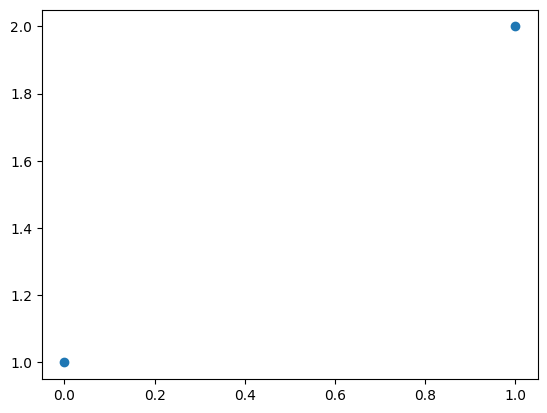

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
import seis_forward_old
import seis_forward
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [2]:
importlib.reload(kgs)
data = kgs.Data()
data.seismogram.filename = 'F:\\seismic\\data\\train_samples\\FlatVel_A/data\\data1.npy'
data.seismogram.ind=5
data.velocity = kgs.Velocity()
data.velocity.filename = 'F:\\seismic\\data\\train_samples\\FlatVel_A/model\\model1.npy'
data.velocity.ind=5
data.check_constraints()
data.load_to_memory()
#data.unload()

In [3]:
importlib.reload(kgs)
data=kgs.load_all_train_data()
print(len(data))
for d in data:
    d.check_constraints()

10000


In [57]:
%%time
importlib.reload(seis_forward_old)
kgs.profiling=False
data[0].load_to_memory()
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data, data[0].velocity.min_vel)
#seis_pred = seis_forward.vel_to_seis(data[0].velocity, data[0].seismogram).data
seis_pred = seis_forward_old.vel_to_seis(data[0].velocity.data,data[0].velocity.min_vel)[:,2:,:]
kgs.rms(seis_pred[:,:,:]-data[0].seismogram.data[:,:,:])    

CPU times: total: 328 ms
Wall time: 344 ms


6.1522696e-05

In [67]:
%%time
importlib.reload(seis_forward)
kgs.profiling=False
data[0].load_to_memory()
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data, data[0].velocity.min_vel)
seis_pred = seis_forward.vel_to_seis(data[0].velocity, data[0].seismogram).data
#seis_pred = seis_forward.vel_to_seis(data[0].velocity.data,data[0].velocity.min_vel)[:,2:,:]
kgs.rms(seis_pred[:,:,:]-data[0].seismogram.data[:,:,:])    

CPU times: total: 344 ms
Wall time: 351 ms


6.1522696e-05

In [47]:
seis_pred

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

    

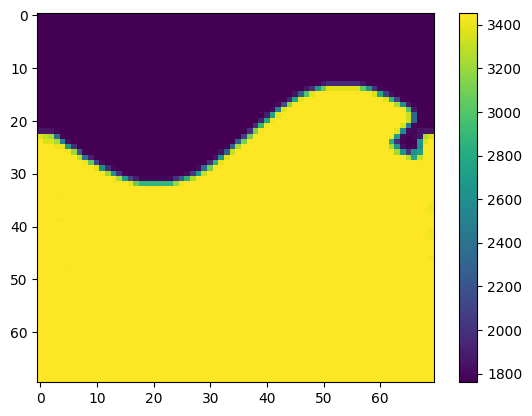

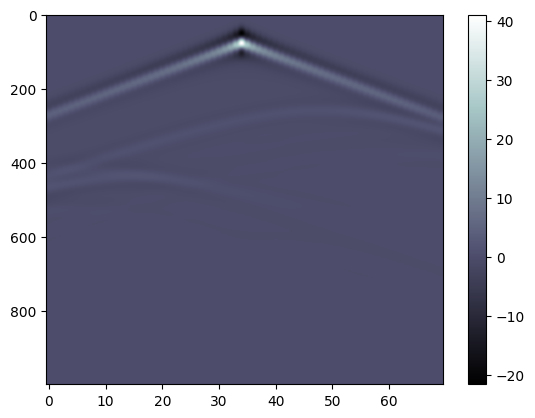

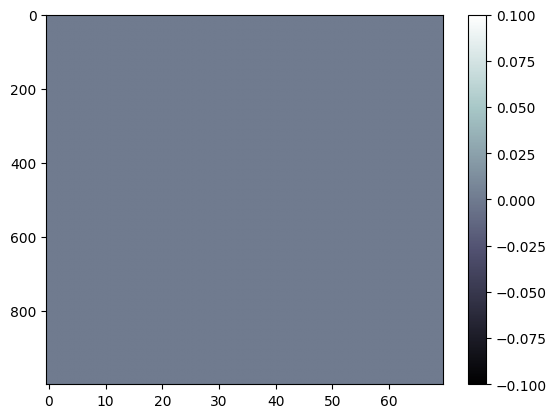

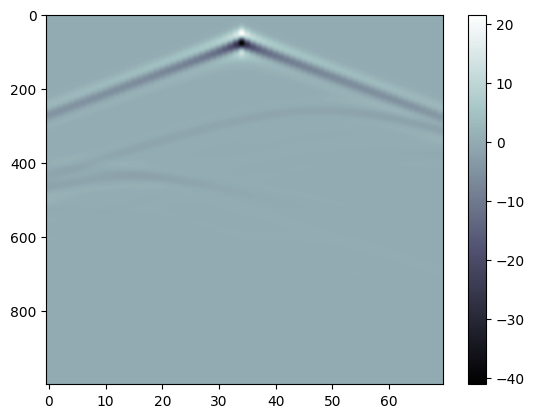

In [46]:
d=data[0]
plt.figure();plt.imshow(d.velocity.data,aspect='auto');plt.colorbar()
plt.figure();plt.imshow(d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()        
plt.figure();plt.imshow(seis_pred[2,...],cmap='bone',aspect='auto');plt.colorbar()     
plt.figure();plt.imshow(seis_pred[2,:,:]-d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()

CurveFault_A 100 100 1.0
CurveFault_B 100 100 1.0
CurveVel_A 100 100 1.0
CurveVel_B 0.10763482


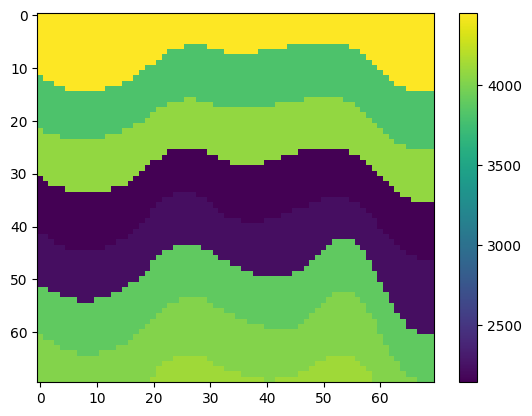

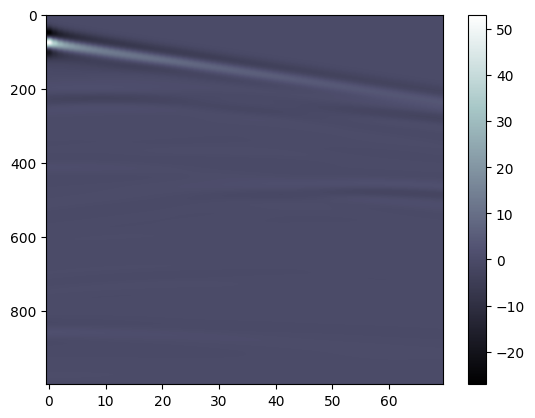

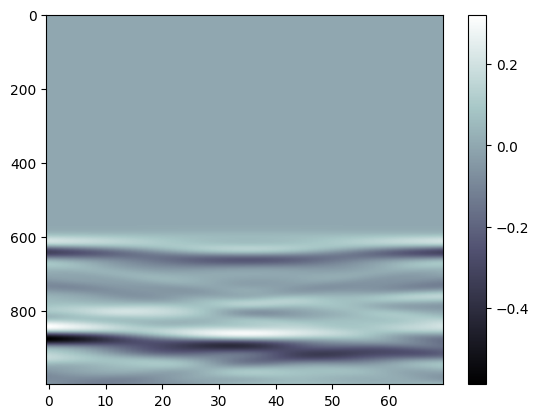

CurveVel_B 0.10634569


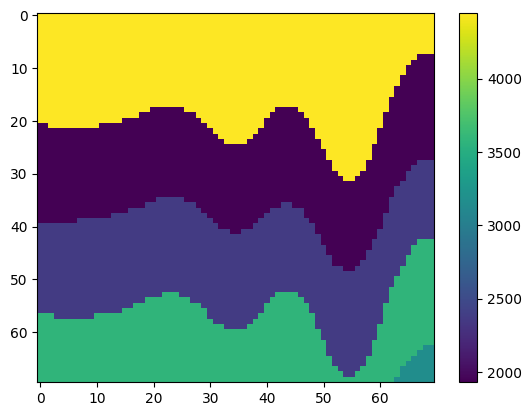

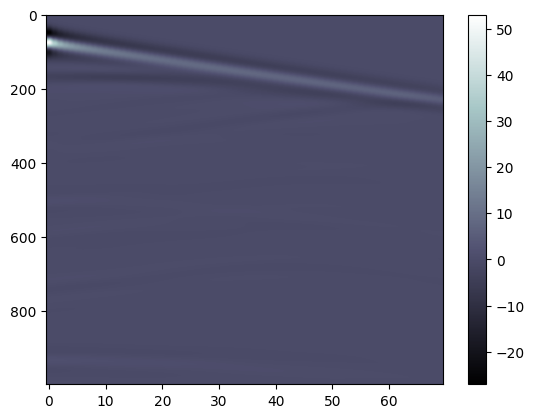

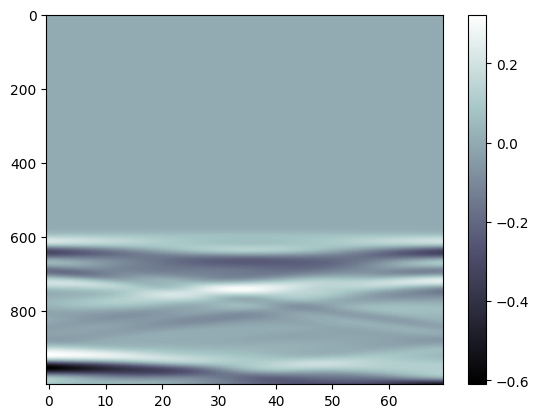

CurveVel_B 0.100898266


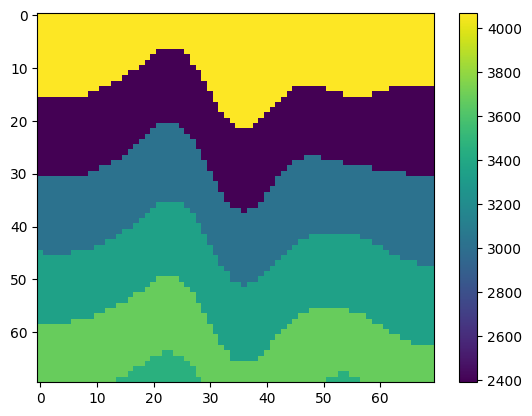

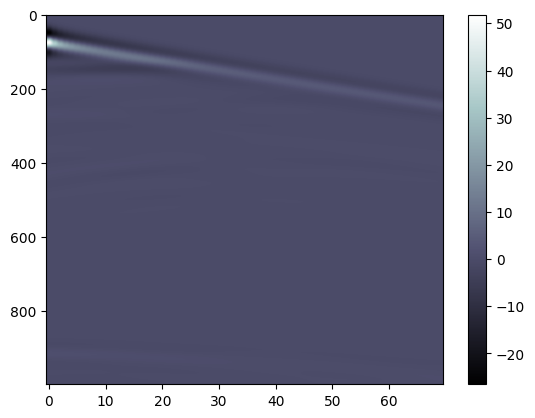

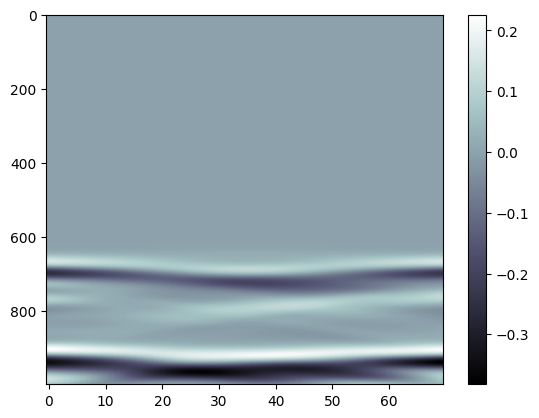

CurveVel_B 0.10185486


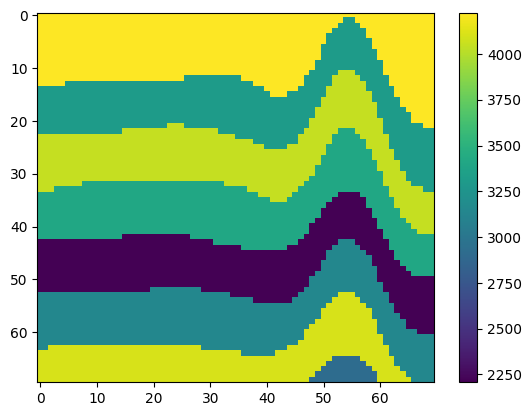

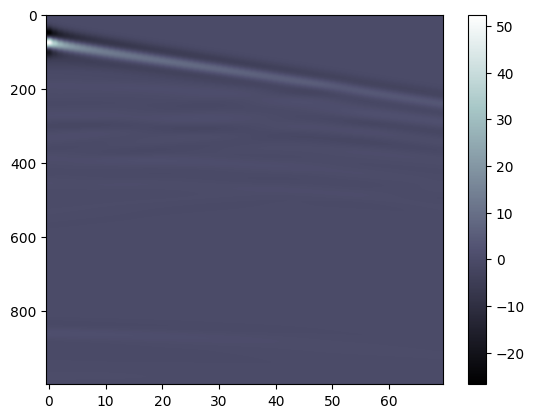

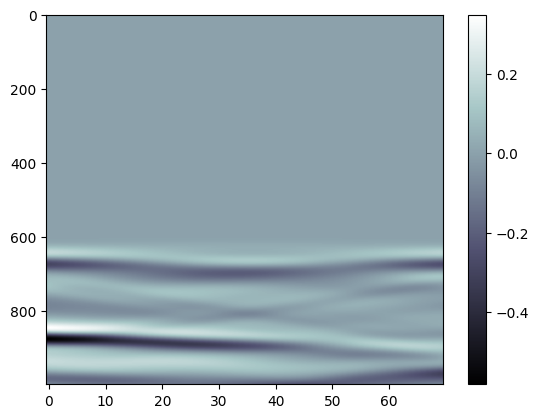

CurveVel_B 96 100 0.96
FlatFault_A 100 100 1.0


In [ ]:
data_shuffled = copy.deepcopy(data)
np.random.default_rng(seed=0).shuffle(data_shuffled)
families = list(dict.fromkeys([d.family for d in data]))
for f in families:
    n_ok = 0
    n_done = 0
    for d in data_shuffled:
        if not d.family==f:
            continue
        d.load_to_memory()
        seis_pred = seis_forward.vel_to_seis(d.velocity.data, d.velocity.min_vel)    
        if kgs.rms(seis_pred[:,2:,:]-d.seismogram.data[:,:,:])<1e-1:
            #print('OK')
            n_ok+=1
        else:
            pass
            print(d.family, kgs.rms(seis_pred[:,2:,:]-d.seismogram.data[:,:,:]))              
            plt.figure();plt.imshow(d.velocity.data,aspect='auto');plt.colorbar()
            plt.figure();plt.imshow(d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()        
            plt.figure();plt.imshow(seis_pred[2,2:,:]-d.seismogram.data[2,...],cmap='bone',aspect='auto');plt.colorbar()
            plt.pause(0.001)
        d.unload()
        n_done += 1
        if n_done>=100:
            break
    print(f,n_ok, n_done, n_ok/n_done)

(35, 100, 0.35)

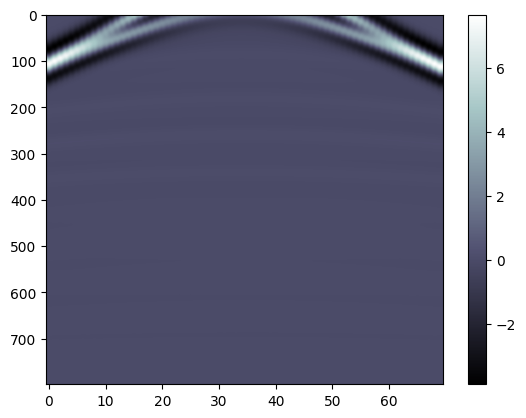

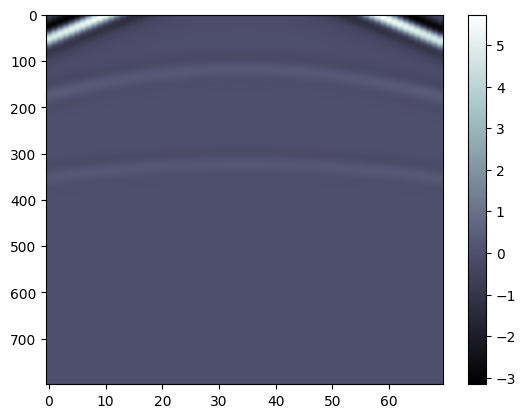

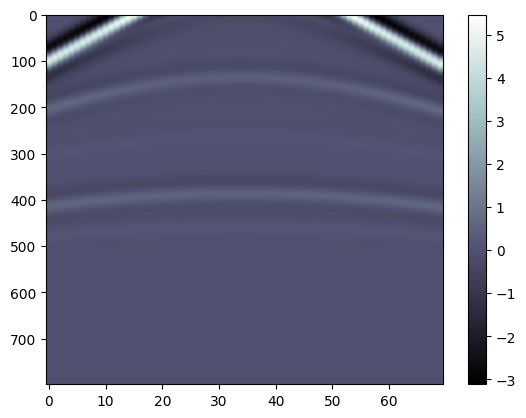

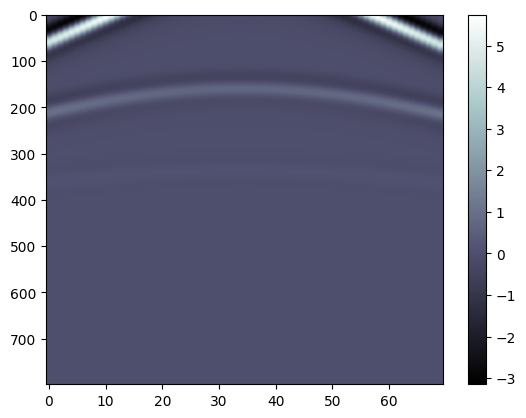

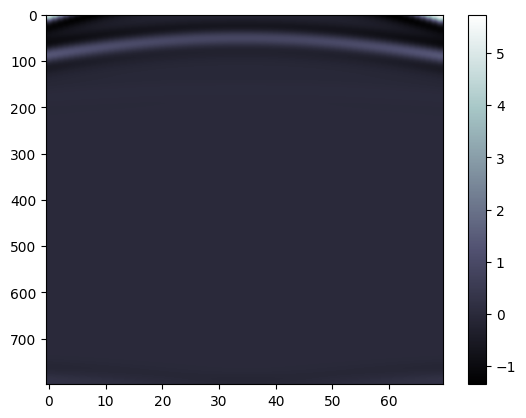

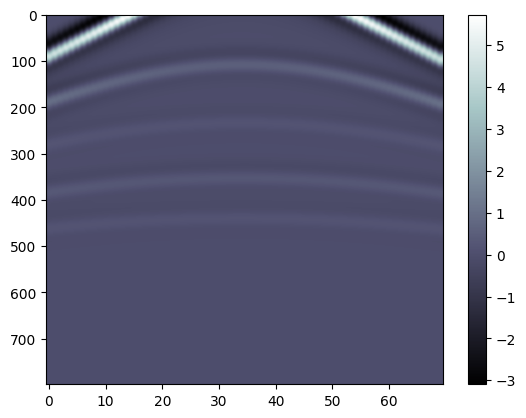

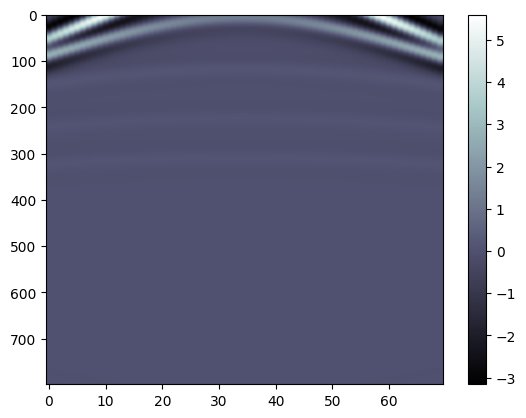

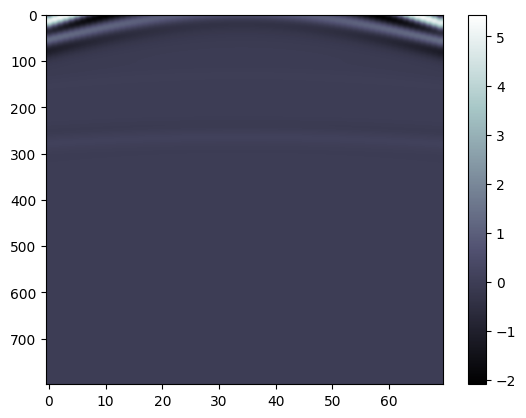

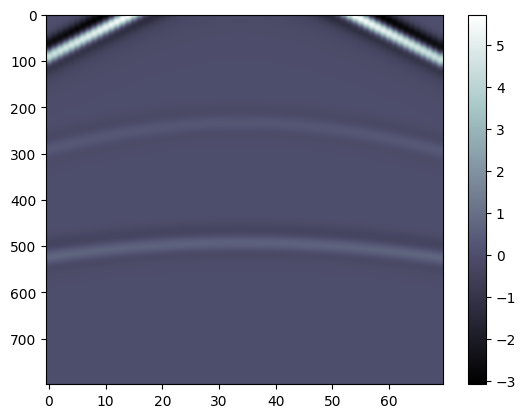

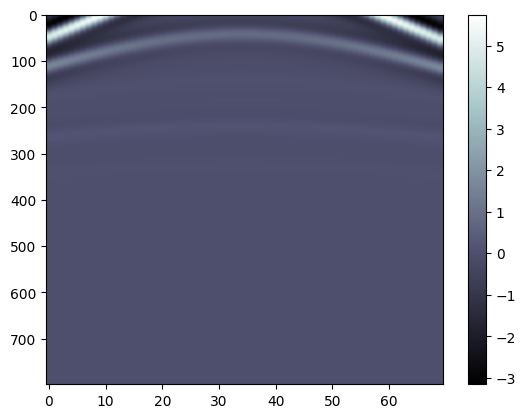

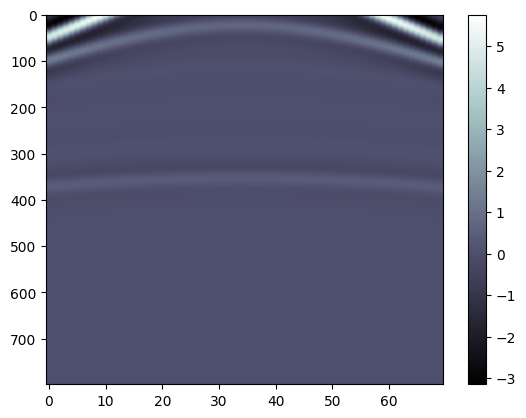

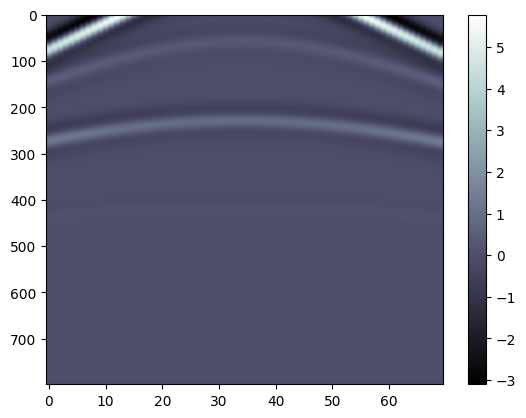

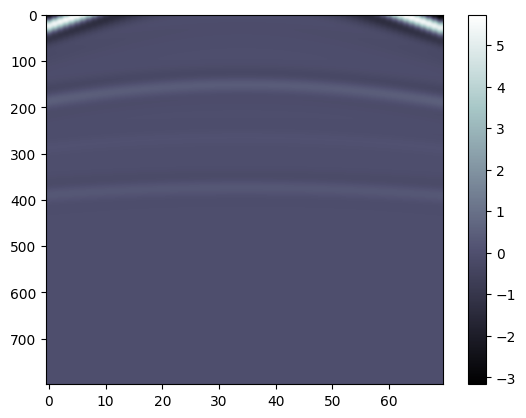

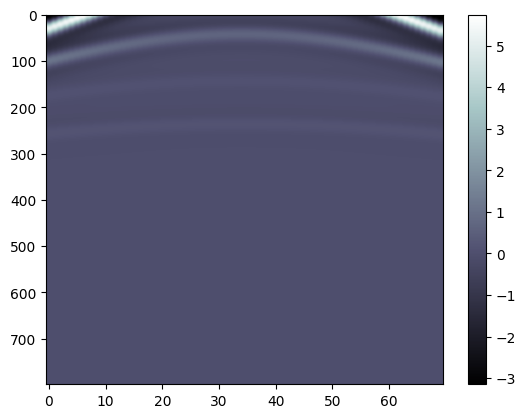

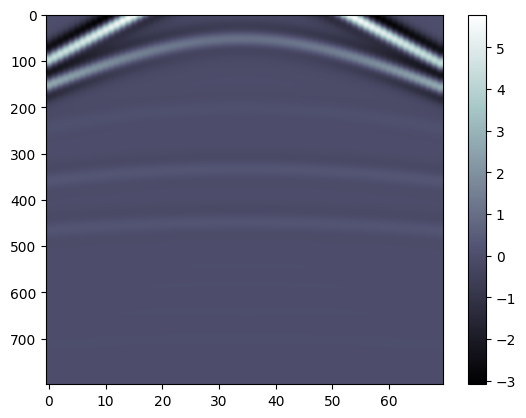

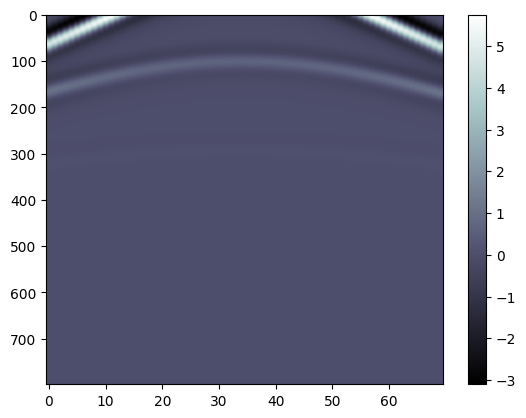

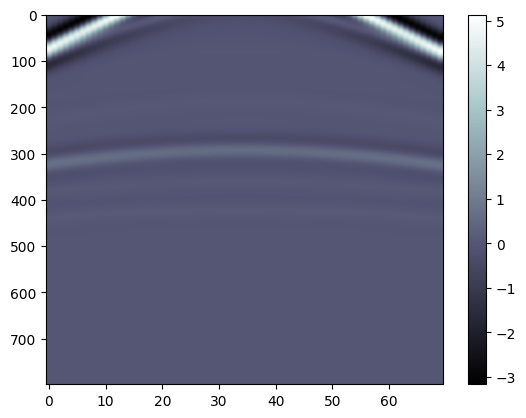

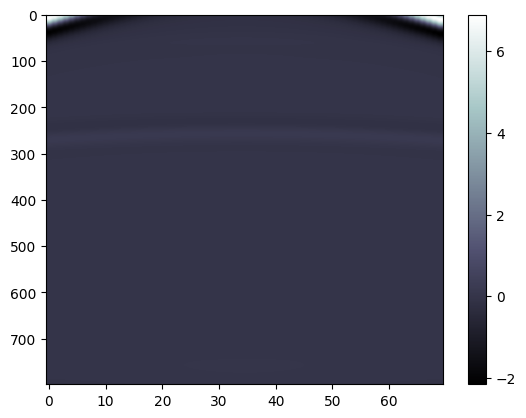

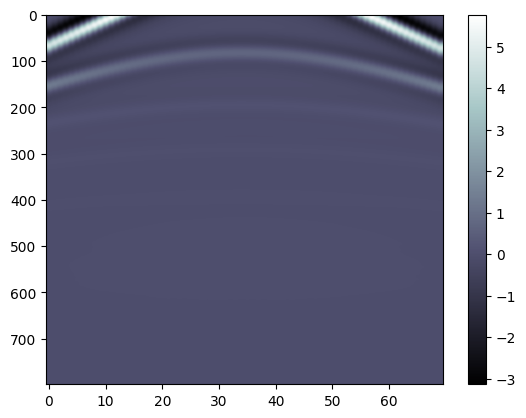

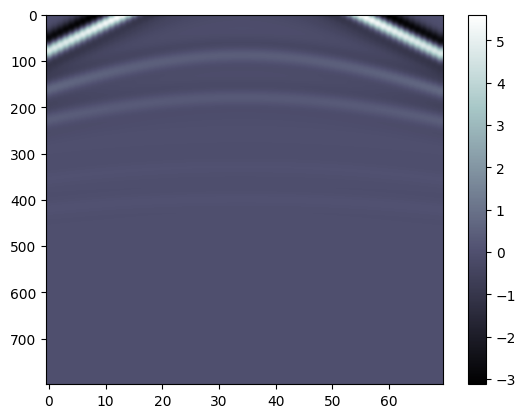

In [37]:
n_done = 0
for d in data:
    if d.family == 'FlatVel_A':
        d.load_to_memory()
        plt.figure();plt.imshow(d.seismogram.data[2,200:,:],cmap='bone', aspect='auto');plt.colorbar()
        d.unload()
        n_done += 1
    if n_done>=20:
        break

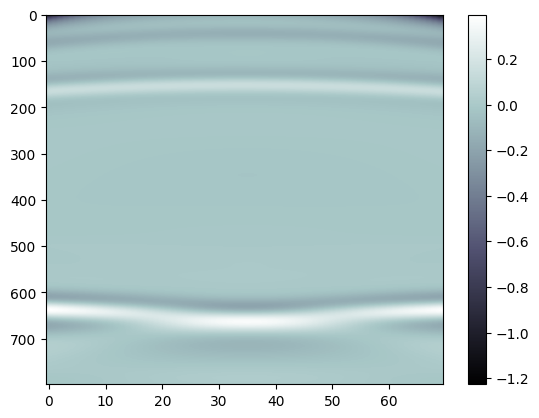

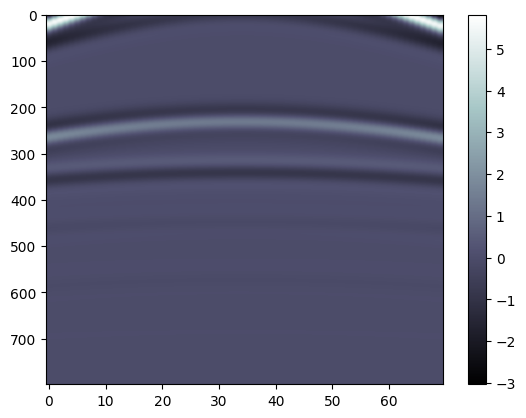

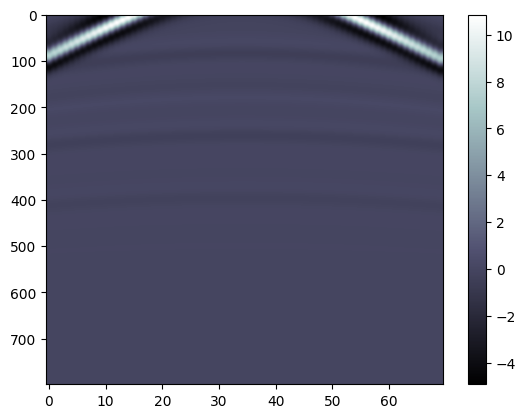

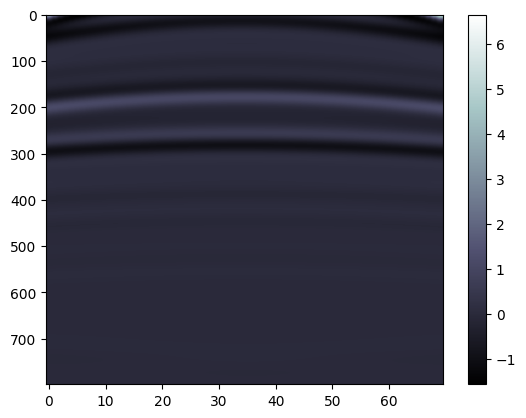

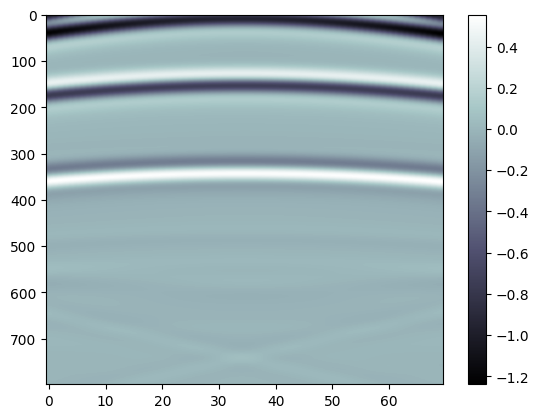

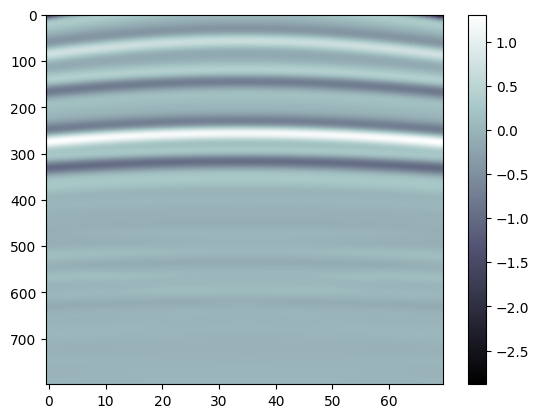

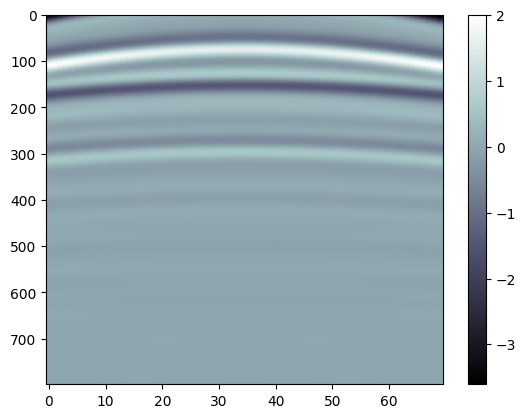

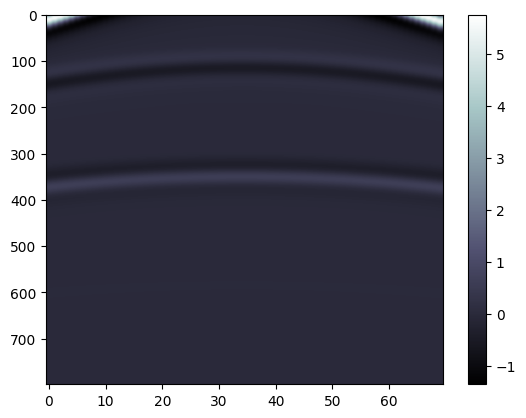

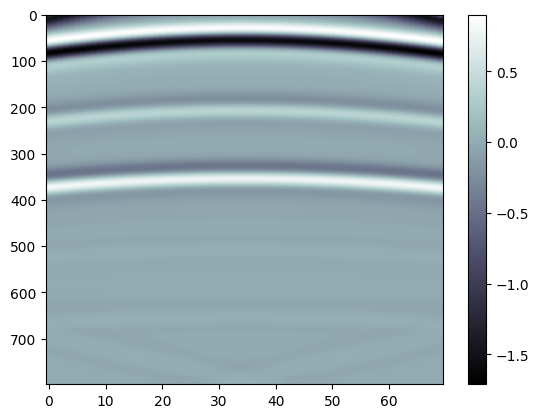

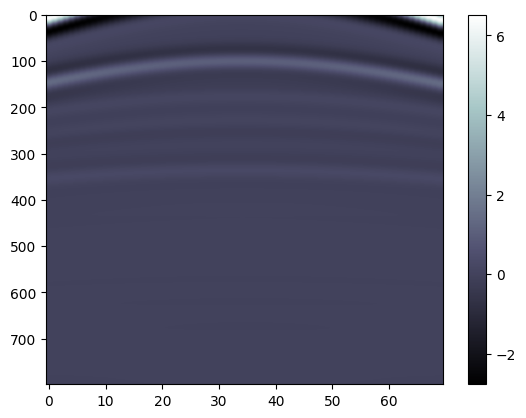

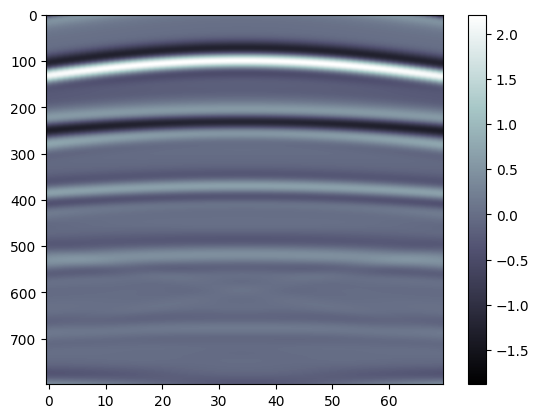

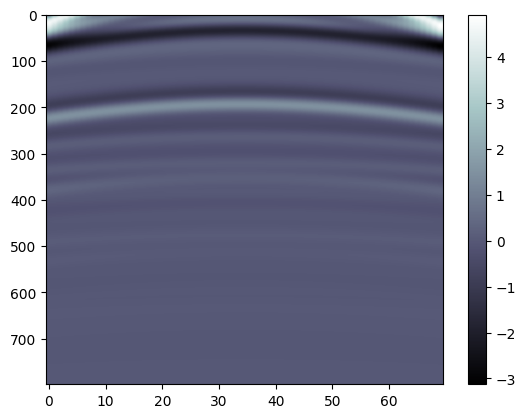

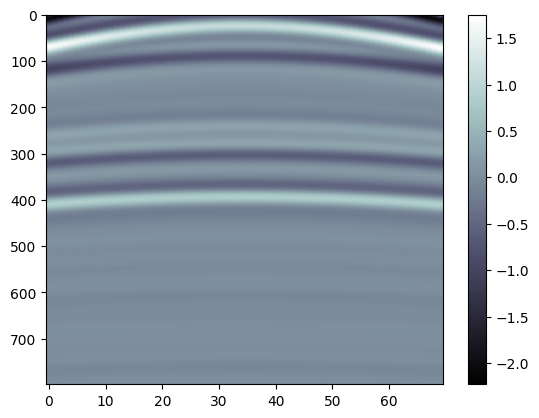

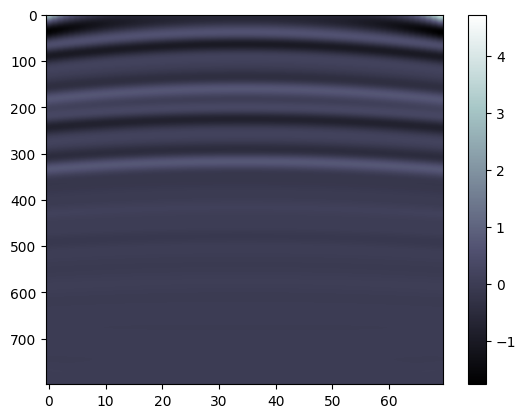

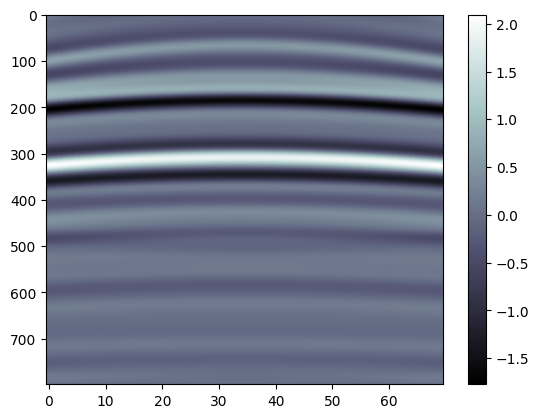

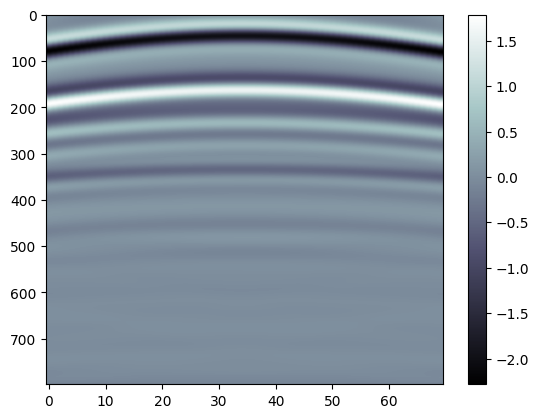

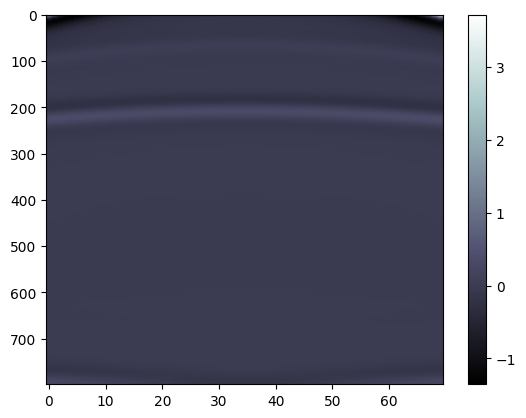

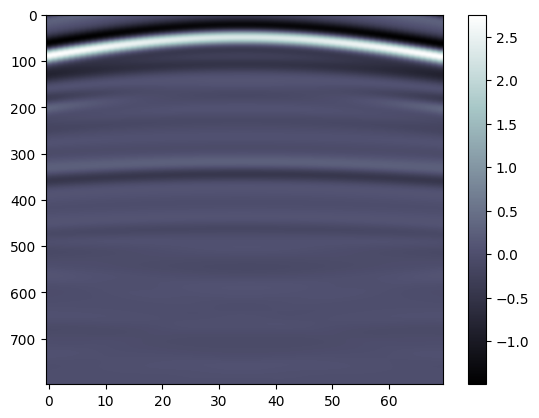

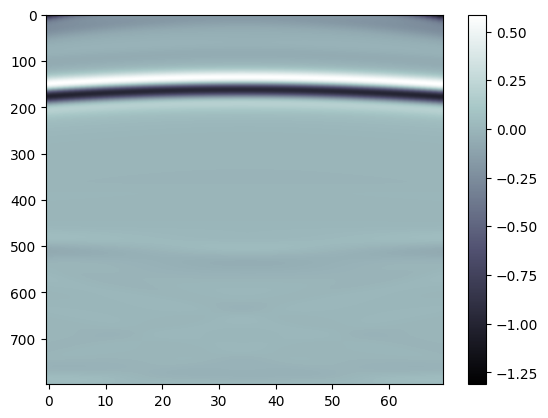

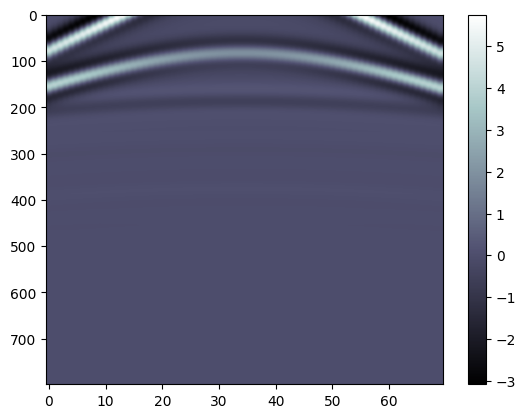

In [39]:
n_done = 0
for d in data:
    if d.family == 'FlatVel_B':
        d.load_to_memory()
        plt.figure();plt.imshow(d.seismogram.data[2,200:,:],cmap='bone', aspect='auto');plt.colorbar()
        d.unload()
        n_done += 1
    if n_done>=20:
        break

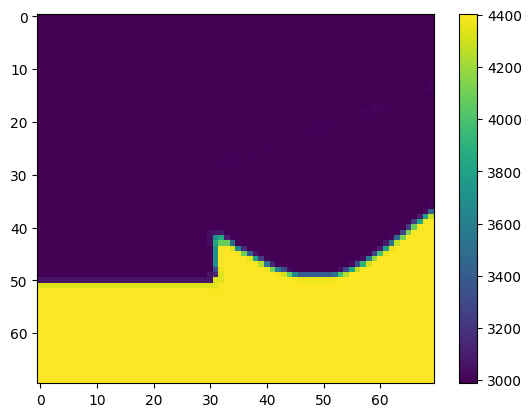

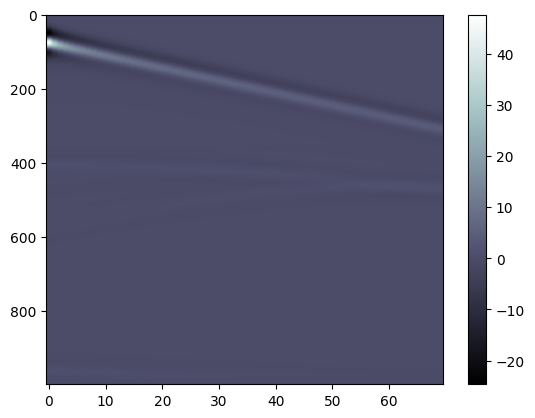

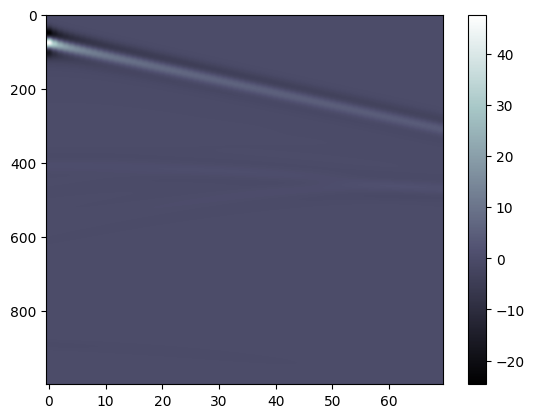

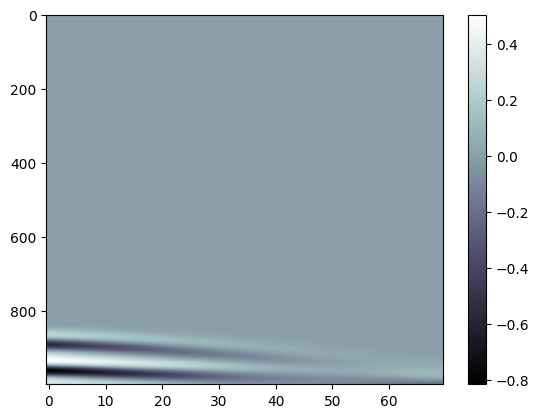

In [ ]:
plt.figure();plt.imshow(d.velocity.data,aspect='auto');plt.colorbar()
plt.figure();plt.imshow(d.seismogram.data[0,...],cmap='bone',aspect='auto');plt.colorbar()
plt.figure();plt.imshow(seis_pred[0,2:,:],cmap='bone',aspect='auto');plt.colorbar()
plt.figure();plt.imshow(seis_pred[0,2:,:]-d.seismogram.data[0,...],cmap='bone',aspect='auto');plt.colorbar()

In [8]:
plt.imshow(data[0].seismogram.data[0,...]-seis_pred[0,:,:],cmap='bone',aspect='auto')

ValueError: operands could not be broadcast together with shapes (999,70) (1001,70) 